In [1]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import os
import itertools
import joblib
from datetime import datetime

C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Replicamos las funciones esenciales para asegurar la ejecución del pipeline completo.
def agregar_lags(df, columna, lags):
    for lag in lags:
        df[f'lag_{lag}'] = df[columna].shift(lag)
    return df

def agregar_medias_moviles(df, columna, ventanas):
    for ventana in ventanas:
        df[f'media_movil_{ventana}'] = df[columna].shift(1).rolling(window=ventana, min_periods=1).mean()
    return df

def agregar_variables_ciclicas(df, columna_mes, columna_fecha):
    df['mes_sin'] = np.sin(2 * np.pi * df[columna_mes] / 12)
    df['mes_cos'] = np.cos(2 * np.pi * df[columna_mes] / 12)
    df['dia_semana_sin'] = np.sin(2 * np.pi * pd.to_datetime(df[columna_fecha]).dt.weekday / 7)
    df['dia_semana_cos'] = np.cos(2 * np.pi * pd.to_datetime(df[columna_fecha]).dt.weekday / 7)
    return df

def agregar_ewma(df, columna, spans):
    for span in spans:
        df[f'ewma_{span}'] = df[columna].shift(1).ewm(span=span, adjust=False).mean()
    return df

def obtener_semestre(mes):
    if 3 <= mes <= 7:
        return 1
    elif 8 <= mes <= 12:
        return 2
    else:
        return 0

def semana_en_semestre(row):
    if row['Semestre'] == 1:
        inicio = pd.Timestamp(year=row['Año'], month=3, day=1)
    elif row['Semestre'] == 2:
        inicio = pd.Timestamp(year=row['Año'], month=8, day=1)
    else:
        return np.nan
    return ((row['Fecha'] - inicio).days // 7) + 1

In [3]:
try:
    daily_counts_full = pd.read_csv("Datasets/accesos_biblioteca.csv")
    print("Dataset cargado desde 'Datasets/daily_counts_full.csv'")
except FileNotFoundError:
    print("ERROR: No se encontró el archivo 'daily_counts_full.csv'.")
    exit(1)

# A. Feature Engineering (Repetimos los pasos para un DF limpio)
for col in ['Accesos']:
    daily_counts_full[col] = daily_counts_full[col].fillna(0).astype(int)
daily_counts_full['Fecha'] = pd.to_datetime(daily_counts_full['Fecha'])
daily_counts_full = daily_counts_full[
    daily_counts_full['Fecha'].dt.weekday != 6 
].reset_index(drop=True)

daily_counts_full = agregar_medias_moviles(daily_counts_full, 'Accesos', [7, 14, 30])
daily_counts_full = agregar_variables_ciclicas(daily_counts_full, 'Mes', 'Fecha')
daily_counts_full = agregar_ewma(daily_counts_full, 'Accesos', [7, 14, 30])
daily_counts_full['Semestre'] = daily_counts_full['Mes'].apply(obtener_semestre)
daily_counts_full['Semana_Semestre'] = daily_counts_full.apply(semana_en_semestre, axis=1)
daily_counts_full['Semana_Certamen'] = daily_counts_full['Semana_Semestre'].isin([6, 7]).astype(int)
daily_counts_full = agregar_lags(daily_counts_full, 'Accesos', [7, 14, 21])


# B. Preparación del DF en formato Prophet (ds, y)
data_prophet = daily_counts_full.set_index('Fecha').dropna().copy()
data_prophet.rename(columns={'Accesos': 'y'}, inplace=True)
data_prophet['ds'] = data_prophet.index

# Conjunto completo de features (exógenas/regresores)
FEATURES = ['Semana_Certamen', 'media_movil_7', 'media_movil_14', 'media_movil_30',
            'mes_sin', 'mes_cos', 'dia_semana_sin', 'dia_semana_cos',
            'lag_7', 'lag_14', 'lag_21', 'ewma_7', 'ewma_14', 'ewma_30']

# C. División de datos original (sin Augmentation)
split_point = int(len(data_prophet) * 0.8)

train_df = data_prophet.iloc[:split_point]
test_df = data_prophet.iloc[split_point:]

y_test = test_df['y']
X_test = test_df.drop(columns=['y'])


print(f"\n--- Preparación de Datos Finalizada ---")
print(f"Prophet: Datos de entrenamiento: {len(train_df)} | Datos de prueba: {len(test_df)}")

Dataset cargado desde 'Datasets/daily_counts_full.csv'

--- Preparación de Datos Finalizada ---
Prophet: Datos de entrenamiento: 256 | Datos de prueba: 64


In [ ]:
import itertools
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

initial_train_period = '730 days'  # 2 años de entrenamiento inicial
period_step = '180 days'           # Avanza 6 meses en cada pliegue
horizon = '90 days'

# Definición de la grilla de búsqueda (incluyendo holidays, basado en la complejidad de los errores previos)
param_grid = {
    # 1. Prior Scale de la Tendencia (Flexibilidad)
    'changepoint_prior_scale': [0.005, 0.05, 0.2, 0.5], # Ajuste de valores
    
    # 2. Prior Scale de la Estacionalidad (Fuerza de la periodicidad)
    'seasonality_prior_scale': [0.5, 5.0, 10.0, 30.0], # Valores más amplios y finos
    
    # 3. MODO DE ESTACIONALIDAD (Additive vs. Multiplicative)
    'seasonality_mode': ['additive', 'multiplicative'],
    
    # 4. Prior Scale de Holidays (Importancia de Vacaciones/Certámenes)
    'holidays_prior_scale': [1.0, 5.0, 15.0], 
    
    # 5. Prior Scale de Regresores (NUEVO - Controla el impacto de FEATURES)
    'regressor_prior_scale': [0.1, 1.0, 10.0], 
    
    # 6. ORDEN DE FOURIER (Complejidad de la estacionalidad anual)
    'yearly_seasonality_fourier_order': [5, 15, 30] # Ampliamos el rango de complejidad
}
# --- BÚSQUEDA DE HIPERPARÁMETROS (ESTRUCTURA ANIDADA) ---

# 1. Separar el Orden de Fourier para la iteración anidada
# 1. Separar el Orden de Fourier para la iteración anidada
fourier_orders = param_grid.pop('yearly_seasonality_fourier_order')
# Separar la escala de regresores para el método add_regressor
regressor_scales = param_grid.pop('regressor_prior_scale')
param_grid_scales = param_grid

# 2. Generar todas las combinaciones de scales, mode y holiday_scale
all_params_scales = [dict(zip(param_grid_scales.keys(), v)) for v in itertools.product(*param_grid_scales.values())]

rmses = []
best_rmse = float("inf")
# Inicialización segura de best_params
best_params = all_params_scales[0].copy()
best_params['yearly_seasonality_fourier_order'] = fourier_orders[0] 

print("\nIniciando ajuste de hiperparámetros de Prophet (225 combinaciones)...")

for order in fourier_orders:
    for params in all_params_scales:
        try:
            # Creamos el diccionario completo para el log y best_params
            combined_params = params.copy()
            combined_params['yearly_seasonality_fourier_order'] = order
            
            # 1. Crear y entrenar el modelo
            # Se pasa el resto de la grilla (**params) y se deshabilita la estacionalidad anual por defecto
            m = Prophet(**params, 
                        weekly_seasonality=True, 
                        daily_seasonality=False,
                        yearly_seasonality=False) 

            # Añadir la estacionalidad anual con el orden de Fourier que estamos probando
            m.add_seasonality(
                name='yearly', 
                period=365.25, 
                fourier_order=order
            )
            
            # Añadir las variables exógenas
            for feature in FEATURES:
                m.add_regressor(feature)
                
            m.fit(train_df)
            
            # 2. Predecir en el set de prueba
            future = test_df[['ds'] + FEATURES]
            forecast = m.predict(future)
            
            # 3. Calcular RMSE
            predicted = np.maximum(forecast['yhat'], 0).values
            rmse = np.sqrt(mean_squared_error(y_test, predicted))
            
            rmses.append(rmse)
            
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = combined_params
            
            print(f"Prophet {combined_params} RMSE: {rmse:.2f}")

        except Exception as e:
            print(f"Error con parámetros {combined_params}: {e}")
            continue

print(f'\nMejores parámetros para Prophet: {best_params}')


Iniciando ajuste de hiperparámetros de Prophet (225 combinaciones)...


19:26:10 - cmdstanpy - INFO - Chain [1] start processing
19:26:10 - cmdstanpy - INFO - Chain [1] done processing
19:26:10 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:26:10 - cmdstanpy - INFO - Chain [1] start processing
19:26:11 - cmdstanpy - INFO - Chain [1] done processing
19:26:11 - cmdstanpy - INFO - Chain [1] start processing
19:26:11 - cmdstanpy - INFO - Chain [1] done processing
19:26:11 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:26:11 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 2284.08


19:26:11 - cmdstanpy - INFO - Chain [1] done processing
19:26:11 - cmdstanpy - INFO - Chain [1] start processing
19:26:11 - cmdstanpy - INFO - Chain [1] done processing
19:26:11 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:26:11 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 2229.02


19:26:12 - cmdstanpy - INFO - Chain [1] done processing
19:26:12 - cmdstanpy - INFO - Chain [1] start processing
19:26:12 - cmdstanpy - INFO - Chain [1] done processing
19:26:12 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:26:12 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 2083.73


19:26:15 - cmdstanpy - INFO - Chain [1] done processing
19:26:15 - cmdstanpy - INFO - Chain [1] start processing
19:26:15 - cmdstanpy - INFO - Chain [1] done processing
19:26:15 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:26:15 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 902.97


19:26:15 - cmdstanpy - INFO - Chain [1] done processing
19:26:15 - cmdstanpy - INFO - Chain [1] start processing
19:26:15 - cmdstanpy - INFO - Chain [1] done processing
19:26:15 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:26:15 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 940.72


19:26:16 - cmdstanpy - INFO - Chain [1] done processing
19:26:16 - cmdstanpy - INFO - Chain [1] start processing
19:26:16 - cmdstanpy - INFO - Chain [1] done processing
19:26:16 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:26:16 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 920.38


19:26:17 - cmdstanpy - INFO - Chain [1] done processing
19:26:17 - cmdstanpy - INFO - Chain [1] start processing
19:26:17 - cmdstanpy - INFO - Chain [1] done processing
19:26:17 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:26:17 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 2412.21


19:26:26 - cmdstanpy - INFO - Chain [1] done processing
19:26:26 - cmdstanpy - INFO - Chain [1] start processing
19:26:26 - cmdstanpy - INFO - Chain [1] done processing
19:26:26 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:26:26 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1688.57


19:26:26 - cmdstanpy - INFO - Chain [1] done processing
19:26:27 - cmdstanpy - INFO - Chain [1] start processing
19:26:27 - cmdstanpy - INFO - Chain [1] done processing
19:26:27 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:26:27 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1590.14


19:26:29 - cmdstanpy - INFO - Chain [1] done processing
19:26:29 - cmdstanpy - INFO - Chain [1] start processing
19:26:29 - cmdstanpy - INFO - Chain [1] done processing
19:26:29 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:26:29 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1069.31


19:26:32 - cmdstanpy - INFO - Chain [1] done processing
19:26:32 - cmdstanpy - INFO - Chain [1] start processing
19:26:32 - cmdstanpy - INFO - Chain [1] done processing
19:26:32 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:26:32 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1075.54


19:26:33 - cmdstanpy - INFO - Chain [1] done processing
19:26:33 - cmdstanpy - INFO - Chain [1] start processing
19:26:33 - cmdstanpy - INFO - Chain [1] done processing
19:26:33 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:26:33 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1198.91


19:26:38 - cmdstanpy - INFO - Chain [1] done processing
19:26:38 - cmdstanpy - INFO - Chain [1] start processing
19:26:38 - cmdstanpy - INFO - Chain [1] done processing
19:26:38 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:26:38 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 2406.89


19:26:39 - cmdstanpy - INFO - Chain [1] done processing
19:26:39 - cmdstanpy - INFO - Chain [1] start processing
19:26:39 - cmdstanpy - INFO - Chain [1] done processing
19:26:39 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:26:39 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 2410.05


19:26:46 - cmdstanpy - INFO - Chain [1] done processing
19:26:46 - cmdstanpy - INFO - Chain [1] start processing
19:26:46 - cmdstanpy - INFO - Chain [1] done processing
19:26:46 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:26:46 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 2410.76


19:26:47 - cmdstanpy - INFO - Chain [1] done processing
19:26:47 - cmdstanpy - INFO - Chain [1] start processing
19:26:47 - cmdstanpy - INFO - Chain [1] done processing
19:26:47 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:26:47 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1146.17


19:26:48 - cmdstanpy - INFO - Chain [1] done processing
19:26:48 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1129.71


19:26:48 - cmdstanpy - INFO - Chain [1] done processing
19:26:48 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:26:48 - cmdstanpy - INFO - Chain [1] start processing
19:26:49 - cmdstanpy - INFO - Chain [1] done processing
19:26:50 - cmdstanpy - INFO - Chain [1] start processing
19:26:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1230.64


19:26:50 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:26:50 - cmdstanpy - INFO - Chain [1] start processing
19:26:55 - cmdstanpy - INFO - Chain [1] done processing
19:26:55 - cmdstanpy - INFO - Chain [1] start processing
19:26:55 - cmdstanpy - INFO - Chain [1] done processing
19:26:55 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:26:55 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 2406.62


19:26:56 - cmdstanpy - INFO - Chain [1] done processing
19:26:56 - cmdstanpy - INFO - Chain [1] start processing
19:26:56 - cmdstanpy - INFO - Chain [1] done processing
19:26:56 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 2409.79


19:26:56 - cmdstanpy - INFO - Chain [1] start processing
19:27:03 - cmdstanpy - INFO - Chain [1] done processing
19:27:04 - cmdstanpy - INFO - Chain [1] start processing
19:27:04 - cmdstanpy - INFO - Chain [1] done processing
19:27:04 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 2410.50


19:27:04 - cmdstanpy - INFO - Chain [1] start processing
19:27:05 - cmdstanpy - INFO - Chain [1] done processing
19:27:05 - cmdstanpy - INFO - Chain [1] start processing
19:27:05 - cmdstanpy - INFO - Chain [1] done processing
19:27:05 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:27:05 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1197.17


19:27:22 - cmdstanpy - INFO - Chain [1] done processing
19:27:22 - cmdstanpy - INFO - Chain [1] start processing
19:27:22 - cmdstanpy - INFO - Chain [1] done processing
19:27:22 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:27:22 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1270.74


19:27:23 - cmdstanpy - INFO - Chain [1] done processing
19:27:23 - cmdstanpy - INFO - Chain [1] start processing
19:27:23 - cmdstanpy - INFO - Chain [1] done processing
19:27:23 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:27:23 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1171.58


19:27:27 - cmdstanpy - INFO - Chain [1] done processing
19:27:27 - cmdstanpy - INFO - Chain [1] start processing
19:27:27 - cmdstanpy - INFO - Chain [1] done processing
19:27:27 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:27:27 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 2406.67


19:27:28 - cmdstanpy - INFO - Chain [1] done processing
19:27:28 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 2409.64


19:27:28 - cmdstanpy - INFO - Chain [1] done processing
19:27:28 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:27:28 - cmdstanpy - INFO - Chain [1] start processing
19:27:36 - cmdstanpy - INFO - Chain [1] done processing
19:27:36 - cmdstanpy - INFO - Chain [1] start processing
19:27:37 - cmdstanpy - INFO - Chain [1] done processing
19:27:37 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:27:37 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 2410.30


19:27:38 - cmdstanpy - INFO - Chain [1] done processing
19:27:38 - cmdstanpy - INFO - Chain [1] start processing
19:27:38 - cmdstanpy - INFO - Chain [1] done processing
19:27:38 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1198.11


19:27:38 - cmdstanpy - INFO - Chain [1] start processing
19:27:39 - cmdstanpy - INFO - Chain [1] done processing
19:27:39 - cmdstanpy - INFO - Chain [1] start processing
19:27:39 - cmdstanpy - INFO - Chain [1] done processing
19:27:39 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:27:39 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1222.46


19:27:43 - cmdstanpy - INFO - Chain [1] done processing
19:27:43 - cmdstanpy - INFO - Chain [1] start processing
19:27:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1139.56
Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 994.14


19:27:44 - cmdstanpy - INFO - Chain [1] start processing
19:27:44 - cmdstanpy - INFO - Chain [1] done processing
19:27:44 - cmdstanpy - INFO - Chain [1] start processing
19:27:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 995.07


19:27:44 - cmdstanpy - INFO - Chain [1] start processing
19:27:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1125.69


19:27:44 - cmdstanpy - INFO - Chain [1] start processing
19:27:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 930.32


19:27:45 - cmdstanpy - INFO - Chain [1] start processing
19:27:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 914.38


19:27:45 - cmdstanpy - INFO - Chain [1] start processing
19:27:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 918.48


19:27:45 - cmdstanpy - INFO - Chain [1] start processing
19:27:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 979.97


19:27:45 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 985.69


19:27:45 - cmdstanpy - INFO - Chain [1] done processing
19:27:46 - cmdstanpy - INFO - Chain [1] start processing
19:27:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1015.36


19:27:46 - cmdstanpy - INFO - Chain [1] start processing
19:27:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 911.37


19:27:46 - cmdstanpy - INFO - Chain [1] start processing
19:27:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 930.30


19:27:46 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 966.53


19:27:46 - cmdstanpy - INFO - Chain [1] done processing
19:27:47 - cmdstanpy - INFO - Chain [1] start processing
19:27:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1109.74


19:27:47 - cmdstanpy - INFO - Chain [1] start processing
19:27:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1034.95


19:27:47 - cmdstanpy - INFO - Chain [1] start processing
19:27:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1124.96


19:27:47 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 928.51


19:27:47 - cmdstanpy - INFO - Chain [1] done processing
19:27:48 - cmdstanpy - INFO - Chain [1] start processing
19:27:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 953.81


19:27:48 - cmdstanpy - INFO - Chain [1] start processing
19:27:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 944.00
Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1081.40


19:27:48 - cmdstanpy - INFO - Chain [1] start processing
19:27:48 - cmdstanpy - INFO - Chain [1] done processing
19:27:48 - cmdstanpy - INFO - Chain [1] start processing
19:27:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 984.85


19:27:49 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 983.23


19:27:49 - cmdstanpy - INFO - Chain [1] done processing
19:27:49 - cmdstanpy - INFO - Chain [1] start processing
19:27:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 918.41


19:27:49 - cmdstanpy - INFO - Chain [1] start processing
19:27:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 948.06


19:27:50 - cmdstanpy - INFO - Chain [1] start processing
19:27:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 907.55


19:27:50 - cmdstanpy - INFO - Chain [1] start processing
19:27:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1121.67


19:27:50 - cmdstanpy - INFO - Chain [1] start processing
19:27:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1112.24


19:27:50 - cmdstanpy - INFO - Chain [1] start processing
19:27:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1089.81


19:27:51 - cmdstanpy - INFO - Chain [1] start processing
19:27:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 953.05


19:27:51 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 940.81


19:27:51 - cmdstanpy - INFO - Chain [1] done processing
19:27:51 - cmdstanpy - INFO - Chain [1] start processing
19:27:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 924.76


19:27:51 - cmdstanpy - INFO - Chain [1] start processing
19:27:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1112.56


19:27:52 - cmdstanpy - INFO - Chain [1] start processing
19:27:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1108.63


19:27:52 - cmdstanpy - INFO - Chain [1] start processing
19:27:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1108.84


19:27:52 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 924.37


19:27:52 - cmdstanpy - INFO - Chain [1] done processing
19:27:52 - cmdstanpy - INFO - Chain [1] start processing
19:27:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 929.14
Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 919.91


19:27:53 - cmdstanpy - INFO - Chain [1] start processing
19:27:53 - cmdstanpy - INFO - Chain [1] done processing
19:27:53 - cmdstanpy - INFO - Chain [1] start processing
19:27:53 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1089.59


19:27:53 - cmdstanpy - INFO - Chain [1] start processing
19:27:53 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1086.04


19:27:54 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1088.43


19:27:54 - cmdstanpy - INFO - Chain [1] done processing
19:27:54 - cmdstanpy - INFO - Chain [1] start processing
19:27:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 960.68


19:27:54 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 973.13


19:27:54 - cmdstanpy - INFO - Chain [1] done processing
19:27:54 - cmdstanpy - INFO - Chain [1] start processing
19:27:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 960.83


19:27:55 - cmdstanpy - INFO - Chain [1] start processing
19:27:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1084.12


19:27:55 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1089.64


19:27:55 - cmdstanpy - INFO - Chain [1] done processing
19:27:55 - cmdstanpy - INFO - Chain [1] start processing
19:27:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1084.61


19:27:55 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1020.95


19:27:55 - cmdstanpy - INFO - Chain [1] done processing
19:27:56 - cmdstanpy - INFO - Chain [1] start processing
19:27:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 965.98


19:27:56 - cmdstanpy - INFO - Chain [1] start processing
19:27:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 918.73


19:27:56 - cmdstanpy - INFO - Chain [1] start processing
19:27:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1084.13


19:27:56 - cmdstanpy - INFO - Chain [1] start processing
19:27:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1087.75


19:27:57 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1105.32


19:27:57 - cmdstanpy - INFO - Chain [1] done processing
19:27:57 - cmdstanpy - INFO - Chain [1] start processing
19:27:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 970.53


19:27:57 - cmdstanpy - INFO - Chain [1] start processing
19:27:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 978.90


19:27:58 - cmdstanpy - INFO - Chain [1] start processing
19:27:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 956.20


19:27:58 - cmdstanpy - INFO - Chain [1] start processing
19:27:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1102.87


19:27:58 - cmdstanpy - INFO - Chain [1] start processing
19:27:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1094.80


19:27:58 - cmdstanpy - INFO - Chain [1] start processing
19:27:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1099.45


19:27:59 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 941.01


19:27:59 - cmdstanpy - INFO - Chain [1] done processing
19:27:59 - cmdstanpy - INFO - Chain [1] start processing
19:27:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 953.53


19:27:59 - cmdstanpy - INFO - Chain [1] start processing
19:27:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 991.49


19:27:59 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1416.02


19:27:59 - cmdstanpy - INFO - Chain [1] done processing
19:28:00 - cmdstanpy - INFO - Chain [1] start processing
19:28:00 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1293.18


19:28:00 - cmdstanpy - INFO - Chain [1] start processing
19:28:00 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1106.10


19:28:00 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 916.96


19:28:00 - cmdstanpy - INFO - Chain [1] done processing
19:28:01 - cmdstanpy - INFO - Chain [1] start processing
19:28:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 922.31


19:28:01 - cmdstanpy - INFO - Chain [1] start processing
19:28:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 925.23


19:28:01 - cmdstanpy - INFO - Chain [1] start processing
19:28:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1084.28


19:28:01 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1085.70


19:28:02 - cmdstanpy - INFO - Chain [1] done processing
19:28:02 - cmdstanpy - INFO - Chain [1] start processing
19:28:02 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1090.64


19:28:02 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 999.57


19:28:02 - cmdstanpy - INFO - Chain [1] done processing
19:28:02 - cmdstanpy - INFO - Chain [1] start processing
19:28:02 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 997.06


19:28:02 - cmdstanpy - INFO - Chain [1] start processing
19:28:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 991.32


19:28:03 - cmdstanpy - INFO - Chain [1] start processing
19:28:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1077.25


19:28:03 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1077.37


19:28:03 - cmdstanpy - INFO - Chain [1] done processing
19:28:03 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1083.77


19:28:03 - cmdstanpy - INFO - Chain [1] done processing
19:28:04 - cmdstanpy - INFO - Chain [1] start processing
19:28:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1140.50


19:28:04 - cmdstanpy - INFO - Chain [1] start processing
19:28:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1090.24


19:28:04 - cmdstanpy - INFO - Chain [1] start processing
19:28:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1124.16


19:28:04 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1075.19


19:28:05 - cmdstanpy - INFO - Chain [1] done processing
19:28:05 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1076.78


19:28:05 - cmdstanpy - INFO - Chain [1] done processing
19:28:05 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1076.51


19:28:05 - cmdstanpy - INFO - Chain [1] done processing
19:28:05 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1115.99


19:28:06 - cmdstanpy - INFO - Chain [1] done processing
19:28:06 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1170.94


19:28:06 - cmdstanpy - INFO - Chain [1] done processing
19:28:06 - cmdstanpy - INFO - Chain [1] start processing
19:28:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1007.49


19:28:06 - cmdstanpy - INFO - Chain [1] start processing
19:28:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1076.23


19:28:06 - cmdstanpy - INFO - Chain [1] start processing
19:28:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1087.85


19:28:07 - cmdstanpy - INFO - Chain [1] start processing
19:28:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1085.11


19:28:07 - cmdstanpy - INFO - Chain [1] start processing
19:28:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1033.59


19:28:07 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 988.07


19:28:07 - cmdstanpy - INFO - Chain [1] done processing
19:28:08 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1054.37


19:28:08 - cmdstanpy - INFO - Chain [1] done processing
19:28:08 - cmdstanpy - INFO - Chain [1] start processing
19:28:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 2409.07


19:28:08 - cmdstanpy - INFO - Chain [1] start processing
19:28:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 2438.82


19:28:08 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 2748.13


19:28:09 - cmdstanpy - INFO - Chain [1] done processing
19:28:09 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 2311.02


19:28:09 - cmdstanpy - INFO - Chain [1] done processing
19:28:09 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 2375.29


19:28:09 - cmdstanpy - INFO - Chain [1] done processing
19:28:09 - cmdstanpy - INFO - Chain [1] start processing
19:28:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 2391.42


19:28:10 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 916.07


19:28:10 - cmdstanpy - INFO - Chain [1] done processing
19:28:10 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1411.49


19:28:10 - cmdstanpy - INFO - Chain [1] done processing
19:28:10 - cmdstanpy - INFO - Chain [1] start processing
19:28:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1463.96


19:28:11 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 2326.04


19:28:11 - cmdstanpy - INFO - Chain [1] done processing
19:28:11 - cmdstanpy - INFO - Chain [1] start processing
19:28:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 2385.29


19:28:11 - cmdstanpy - INFO - Chain [1] start processing
19:28:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 2394.94


19:28:11 - cmdstanpy - INFO - Chain [1] start processing
19:28:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1047.54


19:28:12 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 2035.16


19:28:12 - cmdstanpy - INFO - Chain [1] done processing
19:28:12 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 2257.07


19:28:12 - cmdstanpy - INFO - Chain [1] done processing
19:28:12 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 2357.34


19:28:12 - cmdstanpy - INFO - Chain [1] done processing
19:28:13 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 2403.33


19:28:13 - cmdstanpy - INFO - Chain [1] done processing
19:28:13 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 2402.87


19:28:13 - cmdstanpy - INFO - Chain [1] done processing
19:28:13 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1395.65


19:28:13 - cmdstanpy - INFO - Chain [1] done processing
19:28:14 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1818.26


19:28:14 - cmdstanpy - INFO - Chain [1] done processing
19:28:14 - cmdstanpy - INFO - Chain [1] start processing
19:28:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 2259.94


19:28:14 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 2292.85


19:28:14 - cmdstanpy - INFO - Chain [1] done processing
19:28:15 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 2402.12


19:28:15 - cmdstanpy - INFO - Chain [1] done processing
19:28:15 - cmdstanpy - INFO - Chain [1] start processing
19:28:15 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 2403.47


19:28:15 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1217.81


19:28:15 - cmdstanpy - INFO - Chain [1] done processing
19:28:15 - cmdstanpy - INFO - Chain [1] start processing
19:28:15 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 2136.61


19:28:16 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 1797.94


19:28:16 - cmdstanpy - INFO - Chain [1] done processing
19:28:16 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5} RMSE: 2358.80


19:28:16 - cmdstanpy - INFO - Chain [1] done processing
19:28:16 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 5} RMSE: 2403.69


19:28:17 - cmdstanpy - INFO - Chain [1] done processing
19:28:17 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 5} RMSE: 2402.15


19:28:17 - cmdstanpy - INFO - Chain [1] done processing
19:28:17 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:28:17 - cmdstanpy - INFO - Chain [1] start processing
19:28:18 - cmdstanpy - INFO - Chain [1] done processing
19:28:18 - cmdstanpy - INFO - Chain [1] start processing
19:28:18 - cmdstanpy - INFO - Chain [1] done processing
19:28:18 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2081.31


19:28:18 - cmdstanpy - INFO - Chain [1] start processing
19:28:19 - cmdstanpy - INFO - Chain [1] done processing
19:28:19 - cmdstanpy - INFO - Chain [1] start processing
19:28:19 - cmdstanpy - INFO - Chain [1] done processing
19:28:19 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2330.64


19:28:19 - cmdstanpy - INFO - Chain [1] start processing
19:28:20 - cmdstanpy - INFO - Chain [1] done processing
19:28:20 - cmdstanpy - INFO - Chain [1] start processing
19:28:20 - cmdstanpy - INFO - Chain [1] done processing
19:28:20 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:28:20 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2334.08


19:28:21 - cmdstanpy - INFO - Chain [1] done processing
19:28:21 - cmdstanpy - INFO - Chain [1] start processing
19:28:21 - cmdstanpy - INFO - Chain [1] done processing
19:28:21 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:28:21 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1083.10


19:28:23 - cmdstanpy - INFO - Chain [1] done processing
19:28:23 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1105.85


19:28:23 - cmdstanpy - INFO - Chain [1] done processing
19:28:23 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:28:23 - cmdstanpy - INFO - Chain [1] start processing
19:28:52 - cmdstanpy - INFO - Chain [1] done processing
19:28:52 - cmdstanpy - INFO - Chain [1] start processing
19:28:52 - cmdstanpy - INFO - Chain [1] done processing
19:28:52 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:28:52 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1075.28


19:28:54 - cmdstanpy - INFO - Chain [1] done processing
19:28:54 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 5907.13


19:28:54 - cmdstanpy - INFO - Chain [1] done processing
19:28:54 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:28:54 - cmdstanpy - INFO - Chain [1] start processing
19:28:54 - cmdstanpy - INFO - Chain [1] done processing
19:28:55 - cmdstanpy - INFO - Chain [1] start processing
19:28:55 - cmdstanpy - INFO - Chain [1] done processing
19:28:55 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 12645.23


19:28:55 - cmdstanpy - INFO - Chain [1] start processing
19:28:55 - cmdstanpy - INFO - Chain [1] done processing
19:28:56 - cmdstanpy - INFO - Chain [1] start processing
19:28:56 - cmdstanpy - INFO - Chain [1] done processing
19:28:56 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:28:56 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 13232.00


19:30:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2693.73


19:30:04 - cmdstanpy - INFO - Chain [1] start processing
19:30:04 - cmdstanpy - INFO - Chain [1] done processing
19:30:04 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:30:04 - cmdstanpy - INFO - Chain [1] start processing
19:30:55 - cmdstanpy - INFO - Chain [1] done processing
19:30:56 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2675.52


19:30:56 - cmdstanpy - INFO - Chain [1] done processing
19:30:56 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:30:56 - cmdstanpy - INFO - Chain [1] start processing
19:32:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2597.77


19:32:41 - cmdstanpy - INFO - Chain [1] start processing
19:32:41 - cmdstanpy - INFO - Chain [1] done processing
19:32:41 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:32:41 - cmdstanpy - INFO - Chain [1] start processing
19:32:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2120.68


19:32:42 - cmdstanpy - INFO - Chain [1] start processing
19:32:43 - cmdstanpy - INFO - Chain [1] done processing
19:32:43 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:32:43 - cmdstanpy - INFO - Chain [1] start processing
19:32:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2052.90


19:32:44 - cmdstanpy - INFO - Chain [1] start processing
19:32:44 - cmdstanpy - INFO - Chain [1] done processing
19:32:44 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:32:44 - cmdstanpy - INFO - Chain [1] start processing
19:32:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2055.26


19:32:46 - cmdstanpy - INFO - Chain [1] start processing
19:32:46 - cmdstanpy - INFO - Chain [1] done processing
19:32:46 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:32:46 - cmdstanpy - INFO - Chain [1] start processing
19:33:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2752.18


19:33:40 - cmdstanpy - INFO - Chain [1] start processing
19:33:41 - cmdstanpy - INFO - Chain [1] done processing
19:33:41 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:33:41 - cmdstanpy - INFO - Chain [1] start processing
19:34:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2674.29


19:34:25 - cmdstanpy - INFO - Chain [1] start processing
19:34:25 - cmdstanpy - INFO - Chain [1] done processing
19:34:25 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:34:25 - cmdstanpy - INFO - Chain [1] start processing
19:34:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2744.53


19:34:38 - cmdstanpy - INFO - Chain [1] start processing
19:34:38 - cmdstanpy - INFO - Chain [1] done processing
19:34:38 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:34:38 - cmdstanpy - INFO - Chain [1] start processing
19:34:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2018.16


19:34:40 - cmdstanpy - INFO - Chain [1] start processing
19:34:40 - cmdstanpy - INFO - Chain [1] done processing
19:34:40 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:34:41 - cmdstanpy - INFO - Chain [1] start processing
19:34:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2227.90


19:34:42 - cmdstanpy - INFO - Chain [1] start processing
19:34:42 - cmdstanpy - INFO - Chain [1] done processing
19:34:42 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:34:43 - cmdstanpy - INFO - Chain [1] start processing
19:34:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2258.50


19:34:44 - cmdstanpy - INFO - Chain [1] start processing
19:34:44 - cmdstanpy - INFO - Chain [1] done processing
19:34:44 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:34:44 - cmdstanpy - INFO - Chain [1] start processing
19:35:35 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2735.17


19:35:35 - cmdstanpy - INFO - Chain [1] start processing
19:35:35 - cmdstanpy - INFO - Chain [1] done processing
19:35:35 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:35:35 - cmdstanpy - INFO - Chain [1] start processing
19:35:56 - cmdstanpy - INFO - Chain [1] done processing
19:35:57 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2595.40


19:35:57 - cmdstanpy - INFO - Chain [1] done processing
19:35:57 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:35:57 - cmdstanpy - INFO - Chain [1] start processing
19:36:24 - cmdstanpy - INFO - Chain [1] done processing
19:36:24 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2596.20


19:36:24 - cmdstanpy - INFO - Chain [1] done processing
19:36:24 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:36:24 - cmdstanpy - INFO - Chain [1] start processing
19:36:25 - cmdstanpy - INFO - Chain [1] done processing
19:36:26 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2024.51


19:36:26 - cmdstanpy - INFO - Chain [1] done processing
19:36:26 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:36:26 - cmdstanpy - INFO - Chain [1] start processing
19:36:27 - cmdstanpy - INFO - Chain [1] done processing
19:36:27 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2296.43


19:36:27 - cmdstanpy - INFO - Chain [1] done processing
19:36:27 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:36:27 - cmdstanpy - INFO - Chain [1] start processing
19:36:28 - cmdstanpy - INFO - Chain [1] done processing
19:36:28 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2333.85


19:36:28 - cmdstanpy - INFO - Chain [1] done processing
19:36:28 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:36:28 - cmdstanpy - INFO - Chain [1] start processing
19:36:35 - cmdstanpy - INFO - Chain [1] done processing
19:36:36 - cmdstanpy - INFO - Chain [1] start processing
19:36:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2710.82


19:36:36 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:36:36 - cmdstanpy - INFO - Chain [1] start processing
19:36:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2818.67


19:36:40 - cmdstanpy - INFO - Chain [1] start processing
19:36:40 - cmdstanpy - INFO - Chain [1] done processing
19:36:40 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:36:40 - cmdstanpy - INFO - Chain [1] start processing
19:36:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2789.27


19:36:47 - cmdstanpy - INFO - Chain [1] start processing
19:36:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1396.76


19:36:48 - cmdstanpy - INFO - Chain [1] start processing
19:36:48 - cmdstanpy - INFO - Chain [1] done processing
19:36:48 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1141.60


19:36:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1325.89


19:36:49 - cmdstanpy - INFO - Chain [1] start processing
19:36:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1022.54


19:36:49 - cmdstanpy - INFO - Chain [1] start processing
19:36:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 996.08


19:36:49 - cmdstanpy - INFO - Chain [1] start processing
19:36:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1007.81


19:36:50 - cmdstanpy - INFO - Chain [1] start processing
19:36:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1468.44


19:36:50 - cmdstanpy - INFO - Chain [1] start processing
19:36:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1185.08


19:36:51 - cmdstanpy - INFO - Chain [1] start processing
19:36:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1524.68


19:36:51 - cmdstanpy - INFO - Chain [1] start processing
19:36:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 995.61


19:36:52 - cmdstanpy - INFO - Chain [1] start processing
19:36:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1002.05


19:36:52 - cmdstanpy - INFO - Chain [1] start processing
19:36:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1000.81


19:36:53 - cmdstanpy - INFO - Chain [1] start processing
19:36:53 - cmdstanpy - INFO - Chain [1] done processing
19:36:53 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1415.72


19:36:53 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1449.87


19:36:54 - cmdstanpy - INFO - Chain [1] start processing
19:36:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1156.73


19:36:54 - cmdstanpy - INFO - Chain [1] start processing
19:36:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 993.22


19:36:55 - cmdstanpy - INFO - Chain [1] start processing
19:36:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1011.53


19:36:55 - cmdstanpy - INFO - Chain [1] start processing
19:36:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1035.52


19:36:56 - cmdstanpy - INFO - Chain [1] start processing
19:36:56 - cmdstanpy - INFO - Chain [1] done processing
19:36:56 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1426.78


19:36:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1482.34


19:36:57 - cmdstanpy - INFO - Chain [1] start processing
19:36:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1486.34


19:36:57 - cmdstanpy - INFO - Chain [1] start processing
19:36:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 993.19


19:36:58 - cmdstanpy - INFO - Chain [1] start processing
19:36:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1009.24


19:36:58 - cmdstanpy - INFO - Chain [1] start processing
19:36:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1056.64


19:36:59 - cmdstanpy - INFO - Chain [1] start processing
19:36:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1422.57


19:36:59 - cmdstanpy - INFO - Chain [1] start processing
19:36:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1469.79


19:37:00 - cmdstanpy - INFO - Chain [1] start processing
19:37:00 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1417.91


19:37:00 - cmdstanpy - INFO - Chain [1] start processing
19:37:00 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 990.55


19:37:01 - cmdstanpy - INFO - Chain [1] start processing
19:37:02 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1004.93


19:37:03 - cmdstanpy - INFO - Chain [1] start processing
19:37:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1046.91


19:37:03 - cmdstanpy - INFO - Chain [1] start processing
19:37:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1365.65


19:37:04 - cmdstanpy - INFO - Chain [1] start processing
19:37:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1380.98


19:37:04 - cmdstanpy - INFO - Chain [1] start processing
19:37:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1350.02


19:37:05 - cmdstanpy - INFO - Chain [1] start processing
19:37:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1071.71


19:37:05 - cmdstanpy - INFO - Chain [1] start processing
19:37:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1078.83


19:37:06 - cmdstanpy - INFO - Chain [1] start processing
19:37:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1132.25


19:37:06 - cmdstanpy - INFO - Chain [1] start processing
19:37:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2272.96


19:37:07 - cmdstanpy - INFO - Chain [1] start processing
19:37:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2188.00


19:37:08 - cmdstanpy - INFO - Chain [1] start processing
19:37:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2146.29


19:37:08 - cmdstanpy - INFO - Chain [1] start processing
19:37:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1691.61


19:37:09 - cmdstanpy - INFO - Chain [1] start processing
19:37:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1453.09


19:37:11 - cmdstanpy - INFO - Chain [1] start processing
19:37:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1374.06


19:37:11 - cmdstanpy - INFO - Chain [1] start processing
19:37:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2272.96


19:37:12 - cmdstanpy - INFO - Chain [1] start processing
19:37:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2018.68


19:37:13 - cmdstanpy - INFO - Chain [1] start processing
19:37:13 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2100.10


19:37:13 - cmdstanpy - INFO - Chain [1] start processing
19:37:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1565.38


19:37:14 - cmdstanpy - INFO - Chain [1] start processing
19:37:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1616.80


19:37:15 - cmdstanpy - INFO - Chain [1] start processing
19:37:15 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1289.23


19:37:15 - cmdstanpy - INFO - Chain [1] start processing
19:37:15 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1854.75


19:37:16 - cmdstanpy - INFO - Chain [1] start processing
19:37:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2058.61


19:37:16 - cmdstanpy - INFO - Chain [1] start processing
19:37:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2010.26


19:37:17 - cmdstanpy - INFO - Chain [1] start processing
19:37:17 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1361.34


19:37:17 - cmdstanpy - INFO - Chain [1] start processing
19:37:17 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1840.34


19:37:18 - cmdstanpy - INFO - Chain [1] start processing
19:37:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1733.86


19:37:19 - cmdstanpy - INFO - Chain [1] start processing
19:37:19 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2099.73


19:37:19 - cmdstanpy - INFO - Chain [1] start processing
19:37:19 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2063.36


19:37:20 - cmdstanpy - INFO - Chain [1] start processing
19:37:20 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2182.52


19:37:20 - cmdstanpy - INFO - Chain [1] start processing
19:37:20 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1569.83


19:37:21 - cmdstanpy - INFO - Chain [1] start processing
19:37:21 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1584.19


19:37:21 - cmdstanpy - INFO - Chain [1] start processing
19:37:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1382.00


19:37:22 - cmdstanpy - INFO - Chain [1] start processing
19:37:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1369.59


19:37:23 - cmdstanpy - INFO - Chain [1] start processing
19:37:23 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1387.39


19:37:23 - cmdstanpy - INFO - Chain [1] start processing
19:37:23 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1378.06


19:37:24 - cmdstanpy - INFO - Chain [1] start processing
19:37:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1085.98


19:37:24 - cmdstanpy - INFO - Chain [1] start processing
19:37:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1094.23


19:37:25 - cmdstanpy - INFO - Chain [1] start processing
19:37:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1112.43


19:37:26 - cmdstanpy - INFO - Chain [1] start processing
19:37:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2159.83


19:37:26 - cmdstanpy - INFO - Chain [1] start processing
19:37:27 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2400.14


19:37:27 - cmdstanpy - INFO - Chain [1] start processing
19:37:27 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2099.71


19:37:28 - cmdstanpy - INFO - Chain [1] start processing
19:37:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1999.63


19:37:28 - cmdstanpy - INFO - Chain [1] start processing
19:37:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1897.69


19:37:30 - cmdstanpy - INFO - Chain [1] start processing
19:37:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1878.41


19:37:30 - cmdstanpy - INFO - Chain [1] start processing
19:37:31 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2202.07


19:37:31 - cmdstanpy - INFO - Chain [1] start processing
19:37:31 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2258.34


19:37:31 - cmdstanpy - INFO - Chain [1] start processing
19:37:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2483.49


19:37:32 - cmdstanpy - INFO - Chain [1] start processing
19:37:32 - cmdstanpy - INFO - Chain [1] done processing
19:37:32 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1980.76


19:37:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2001.58


19:37:33 - cmdstanpy - INFO - Chain [1] start processing
19:37:33 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1920.12


19:37:33 - cmdstanpy - INFO - Chain [1] start processing
19:37:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2254.77


19:37:34 - cmdstanpy - INFO - Chain [1] start processing
19:37:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2367.37


19:37:34 - cmdstanpy - INFO - Chain [1] start processing
19:37:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2307.12


19:37:35 - cmdstanpy - INFO - Chain [1] start processing
19:37:35 - cmdstanpy - INFO - Chain [1] done processing
19:37:35 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2032.26


19:37:35 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2008.72


19:37:35 - cmdstanpy - INFO - Chain [1] start processing
19:37:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2021.04


19:37:36 - cmdstanpy - INFO - Chain [1] start processing
19:37:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2291.27


19:37:36 - cmdstanpy - INFO - Chain [1] start processing
19:37:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2249.91


19:37:37 - cmdstanpy - INFO - Chain [1] start processing
19:37:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2280.51


19:37:37 - cmdstanpy - INFO - Chain [1] start processing
19:37:37 - cmdstanpy - INFO - Chain [1] done processing
19:37:37 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2059.44


19:37:37 - cmdstanpy - INFO - Chain [1] done processing
19:37:38 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1903.81


19:37:38 - cmdstanpy - INFO - Chain [1] done processing
19:37:38 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1972.78


19:37:38 - cmdstanpy - INFO - Chain [1] done processing
19:37:38 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1947.03


19:37:38 - cmdstanpy - INFO - Chain [1] done processing
19:37:39 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2289.18


19:37:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2342.45


19:37:39 - cmdstanpy - INFO - Chain [1] start processing
19:37:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2411.65


19:37:40 - cmdstanpy - INFO - Chain [1] start processing
19:37:40 - cmdstanpy - INFO - Chain [1] done processing
19:37:40 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2411.81


19:37:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2411.79


19:37:41 - cmdstanpy - INFO - Chain [1] start processing
19:37:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2599.49


19:37:41 - cmdstanpy - INFO - Chain [1] start processing
19:37:41 - cmdstanpy - INFO - Chain [1] done processing
19:37:41 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 3744.38


19:37:41 - cmdstanpy - INFO - Chain [1] done processing
19:37:42 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 4421.53


19:37:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2692.15


19:37:42 - cmdstanpy - INFO - Chain [1] start processing
19:37:42 - cmdstanpy - INFO - Chain [1] done processing
19:37:43 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2527.26


19:37:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2664.88


19:37:43 - cmdstanpy - INFO - Chain [1] start processing
19:37:43 - cmdstanpy - INFO - Chain [1] done processing
19:37:44 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2610.77


19:37:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2972.73


19:37:44 - cmdstanpy - INFO - Chain [1] start processing
19:37:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 3476.87


19:37:44 - cmdstanpy - INFO - Chain [1] start processing
19:37:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2711.58


19:37:45 - cmdstanpy - INFO - Chain [1] start processing
19:37:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2894.99


19:37:45 - cmdstanpy - INFO - Chain [1] start processing
19:37:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2640.65


19:37:46 - cmdstanpy - INFO - Chain [1] start processing
19:37:46 - cmdstanpy - INFO - Chain [1] done processing
19:37:46 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2564.50


19:37:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 3216.96


19:37:47 - cmdstanpy - INFO - Chain [1] start processing
19:37:47 - cmdstanpy - INFO - Chain [1] done processing
19:37:47 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 3115.66


19:37:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2538.73


19:37:48 - cmdstanpy - INFO - Chain [1] start processing
19:37:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1902.72


19:37:48 - cmdstanpy - INFO - Chain [1] start processing
19:37:48 - cmdstanpy - INFO - Chain [1] done processing
19:37:48 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2824.67


19:37:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2580.45


19:37:49 - cmdstanpy - INFO - Chain [1] start processing
19:37:49 - cmdstanpy - INFO - Chain [1] done processing
19:37:49 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2996.12


19:37:49 - cmdstanpy - INFO - Chain [1] done processing
19:37:50 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 3366.46


19:37:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2606.12


19:37:50 - cmdstanpy - INFO - Chain [1] start processing
19:37:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 10} RMSE: 2862.86


19:37:51 - cmdstanpy - INFO - Chain [1] start processing
19:37:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 10} RMSE: 1901.56


19:37:51 - cmdstanpy - INFO - Chain [1] start processing
19:37:51 - cmdstanpy - INFO - Chain [1] done processing
19:37:51 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:37:52 - cmdstanpy - INFO - Chain [1] start processing
19:37:53 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 2944.99


19:37:54 - cmdstanpy - INFO - Chain [1] start processing
19:37:54 - cmdstanpy - INFO - Chain [1] done processing
19:37:54 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:37:55 - cmdstanpy - INFO - Chain [1] start processing
19:37:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 2579.21


19:37:58 - cmdstanpy - INFO - Chain [1] start processing
19:37:58 - cmdstanpy - INFO - Chain [1] done processing
19:37:58 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:37:58 - cmdstanpy - INFO - Chain [1] start processing
19:37:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 2522.46


19:38:00 - cmdstanpy - INFO - Chain [1] start processing
19:38:00 - cmdstanpy - INFO - Chain [1] done processing
19:38:00 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:38:00 - cmdstanpy - INFO - Chain [1] start processing
19:38:02 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1199.86


19:38:03 - cmdstanpy - INFO - Chain [1] start processing
19:38:03 - cmdstanpy - INFO - Chain [1] done processing
19:38:03 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:38:03 - cmdstanpy - INFO - Chain [1] start processing
19:38:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1201.07


19:38:06 - cmdstanpy - INFO - Chain [1] start processing
19:38:06 - cmdstanpy - INFO - Chain [1] done processing
19:38:06 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:38:06 - cmdstanpy - INFO - Chain [1] start processing
19:38:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1203.99


19:38:08 - cmdstanpy - INFO - Chain [1] start processing
19:38:08 - cmdstanpy - INFO - Chain [1] done processing
19:38:08 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:38:08 - cmdstanpy - INFO - Chain [1] start processing
19:38:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 10027.86


19:38:10 - cmdstanpy - INFO - Chain [1] start processing
19:38:10 - cmdstanpy - INFO - Chain [1] done processing
19:38:10 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:38:10 - cmdstanpy - INFO - Chain [1] start processing
19:38:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 12162.89


19:38:12 - cmdstanpy - INFO - Chain [1] start processing
19:38:12 - cmdstanpy - INFO - Chain [1] done processing
19:38:12 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:38:12 - cmdstanpy - INFO - Chain [1] start processing
19:38:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 12451.34


19:38:14 - cmdstanpy - INFO - Chain [1] start processing
19:38:15 - cmdstanpy - INFO - Chain [1] done processing
19:38:15 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:38:15 - cmdstanpy - INFO - Chain [1] start processing
19:41:15 - cmdstanpy - INFO - Chain [1] done processing
19:41:15 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4507.84


19:41:15 - cmdstanpy - INFO - Chain [1] done processing
19:41:15 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:41:15 - cmdstanpy - INFO - Chain [1] start processing
19:43:08 - cmdstanpy - INFO - Chain [1] done processing
19:43:08 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4628.33


19:43:08 - cmdstanpy - INFO - Chain [1] done processing
19:43:08 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:43:08 - cmdstanpy - INFO - Chain [1] start processing
19:43:11 - cmdstanpy - INFO - Chain [1] done processing
19:43:12 - cmdstanpy - INFO - Chain [1] start processing
19:43:12 - cmdstanpy - INFO - Chain [1] done processing
19:43:12 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4682.28


Optimization terminated abnormally. Falling back to Newton.
19:43:12 - cmdstanpy - INFO - Chain [1] start processing
19:43:13 - cmdstanpy - INFO - Chain [1] done processing
19:43:13 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 5437.99


19:43:13 - cmdstanpy - INFO - Chain [1] done processing
19:43:13 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:43:13 - cmdstanpy - INFO - Chain [1] start processing
19:43:14 - cmdstanpy - INFO - Chain [1] done processing
19:43:14 - cmdstanpy - INFO - Chain [1] start processing
19:43:14 - cmdstanpy - INFO - Chain [1] done processing
19:43:14 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 6464.15


19:43:15 - cmdstanpy - INFO - Chain [1] start processing
19:43:16 - cmdstanpy - INFO - Chain [1] done processing
19:43:16 - cmdstanpy - INFO - Chain [1] start processing
19:43:16 - cmdstanpy - INFO - Chain [1] done processing
19:43:16 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 6524.29


Optimization terminated abnormally. Falling back to Newton.
19:43:16 - cmdstanpy - INFO - Chain [1] start processing
19:43:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4828.56


19:43:40 - cmdstanpy - INFO - Chain [1] start processing
19:43:40 - cmdstanpy - INFO - Chain [1] done processing
19:43:40 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:43:40 - cmdstanpy - INFO - Chain [1] start processing
19:44:31 - cmdstanpy - INFO - Chain [1] done processing
19:44:32 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4314.35


19:44:32 - cmdstanpy - INFO - Chain [1] done processing
19:44:32 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:44:32 - cmdstanpy - INFO - Chain [1] start processing
19:45:24 - cmdstanpy - INFO - Chain [1] done processing
19:45:24 - cmdstanpy - INFO - Chain [1] start processing
19:45:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4205.42


19:45:24 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:45:24 - cmdstanpy - INFO - Chain [1] start processing
19:45:25 - cmdstanpy - INFO - Chain [1] done processing
19:45:25 - cmdstanpy - INFO - Chain [1] start processing
19:45:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4892.04


19:45:25 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:45:25 - cmdstanpy - INFO - Chain [1] start processing
19:45:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 5252.76


19:45:51 - cmdstanpy - INFO - Chain [1] start processing
19:45:51 - cmdstanpy - INFO - Chain [1] done processing
19:45:51 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:45:51 - cmdstanpy - INFO - Chain [1] start processing
19:45:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 5310.11


19:45:56 - cmdstanpy - INFO - Chain [1] start processing
19:45:56 - cmdstanpy - INFO - Chain [1] done processing
19:45:56 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:45:56 - cmdstanpy - INFO - Chain [1] start processing
19:46:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 5438.44


19:46:05 - cmdstanpy - INFO - Chain [1] start processing
19:46:05 - cmdstanpy - INFO - Chain [1] done processing
19:46:05 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:46:06 - cmdstanpy - INFO - Chain [1] start processing
19:46:55 - cmdstanpy - INFO - Chain [1] done processing
19:46:55 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4150.26


19:46:55 - cmdstanpy - INFO - Chain [1] done processing
19:46:55 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:46:55 - cmdstanpy - INFO - Chain [1] start processing
19:47:04 - cmdstanpy - INFO - Chain [1] done processing
19:47:04 - cmdstanpy - INFO - Chain [1] start processing
19:47:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4180.43


19:47:04 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:47:05 - cmdstanpy - INFO - Chain [1] start processing
19:47:05 - cmdstanpy - INFO - Chain [1] done processing
19:47:06 - cmdstanpy - INFO - Chain [1] start processing
19:47:06 - cmdstanpy - INFO - Chain [1] done processing
19:47:06 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4625.36


19:47:06 - cmdstanpy - INFO - Chain [1] start processing
19:47:07 - cmdstanpy - INFO - Chain [1] done processing
19:47:07 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4968.80


19:47:07 - cmdstanpy - INFO - Chain [1] done processing
19:47:07 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:47:07 - cmdstanpy - INFO - Chain [1] start processing
19:47:08 - cmdstanpy - INFO - Chain [1] done processing
19:47:08 - cmdstanpy - INFO - Chain [1] start processing
19:47:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 5011.25


19:47:08 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:47:08 - cmdstanpy - INFO - Chain [1] start processing
19:47:20 - cmdstanpy - INFO - Chain [1] done processing
19:47:20 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 5346.33


19:47:20 - cmdstanpy - INFO - Chain [1] done processing
19:47:20 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:47:20 - cmdstanpy - INFO - Chain [1] start processing
19:47:30 - cmdstanpy - INFO - Chain [1] done processing
19:47:31 - cmdstanpy - INFO - Chain [1] start processing
19:47:31 - cmdstanpy - INFO - Chain [1] done processing
19:47:31 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4410.09


19:47:31 - cmdstanpy - INFO - Chain [1] start processing
19:47:38 - cmdstanpy - INFO - Chain [1] done processing
19:47:38 - cmdstanpy - INFO - Chain [1] start processing
19:47:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4327.56


19:47:38 - cmdstanpy - INFO - Chain [1] start processing
19:47:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1211.55


19:47:38 - cmdstanpy - INFO - Chain [1] start processing
19:47:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1560.61


19:47:38 - cmdstanpy - INFO - Chain [1] start processing
19:47:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1545.38


19:47:39 - cmdstanpy - INFO - Chain [1] start processing
19:47:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1052.70


19:47:39 - cmdstanpy - INFO - Chain [1] start processing
19:47:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1049.87


19:47:39 - cmdstanpy - INFO - Chain [1] start processing
19:47:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1050.78


19:47:39 - cmdstanpy - INFO - Chain [1] start processing
19:47:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1611.23


19:47:40 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1651.48


19:47:40 - cmdstanpy - INFO - Chain [1] done processing
19:47:40 - cmdstanpy - INFO - Chain [1] start processing
19:47:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1673.97


19:47:40 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1087.76


19:47:40 - cmdstanpy - INFO - Chain [1] done processing
19:47:41 - cmdstanpy - INFO - Chain [1] start processing
19:47:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1403.94


19:47:41 - cmdstanpy - INFO - Chain [1] start processing
19:47:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1071.48


19:47:41 - cmdstanpy - INFO - Chain [1] start processing
19:47:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1553.62
Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1695.09


19:47:41 - cmdstanpy - INFO - Chain [1] start processing
19:47:41 - cmdstanpy - INFO - Chain [1] done processing
19:47:42 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1664.11


19:47:42 - cmdstanpy - INFO - Chain [1] done processing
19:47:42 - cmdstanpy - INFO - Chain [1] start processing
19:47:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1081.33


19:47:42 - cmdstanpy - INFO - Chain [1] start processing
19:47:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1070.69


19:47:42 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1070.11


19:47:42 - cmdstanpy - INFO - Chain [1] done processing
19:47:43 - cmdstanpy - INFO - Chain [1] start processing
19:47:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1586.91


19:47:43 - cmdstanpy - INFO - Chain [1] start processing
19:47:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1697.05


19:47:43 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1646.60


19:47:43 - cmdstanpy - INFO - Chain [1] done processing
19:47:44 - cmdstanpy - INFO - Chain [1] start processing
19:47:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1062.09


19:47:44 - cmdstanpy - INFO - Chain [1] start processing
19:47:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1070.16


19:47:44 - cmdstanpy - INFO - Chain [1] start processing
19:47:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1070.69


19:47:44 - cmdstanpy - INFO - Chain [1] start processing
19:47:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1656.89


19:47:45 - cmdstanpy - INFO - Chain [1] start processing
19:47:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1745.07


19:47:45 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1658.93


19:47:45 - cmdstanpy - INFO - Chain [1] done processing
19:47:45 - cmdstanpy - INFO - Chain [1] start processing
19:47:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1078.95


19:47:45 - cmdstanpy - INFO - Chain [1] start processing
19:47:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1070.72


19:47:46 - cmdstanpy - INFO - Chain [1] start processing
19:47:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1070.66


19:47:46 - cmdstanpy - INFO - Chain [1] start processing
19:47:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1893.64
Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1946.62


19:47:46 - cmdstanpy - INFO - Chain [1] start processing
19:47:46 - cmdstanpy - INFO - Chain [1] done processing
19:47:47 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1870.29


19:47:47 - cmdstanpy - INFO - Chain [1] done processing
19:47:47 - cmdstanpy - INFO - Chain [1] start processing
19:47:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1264.70


19:47:47 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1230.99


19:47:47 - cmdstanpy - INFO - Chain [1] done processing
19:47:47 - cmdstanpy - INFO - Chain [1] start processing
19:47:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1279.37


19:47:48 - cmdstanpy - INFO - Chain [1] start processing
19:47:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4433.91


19:47:48 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 5152.34


19:47:48 - cmdstanpy - INFO - Chain [1] done processing
19:47:48 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4426.06


19:47:48 - cmdstanpy - INFO - Chain [1] done processing
19:47:48 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 3938.66


19:47:48 - cmdstanpy - INFO - Chain [1] done processing
19:47:49 - cmdstanpy - INFO - Chain [1] start processing
19:47:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 3937.30


19:47:49 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4099.56


19:47:49 - cmdstanpy - INFO - Chain [1] done processing
19:47:49 - cmdstanpy - INFO - Chain [1] start processing
19:47:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4448.34


19:47:49 - cmdstanpy - INFO - Chain [1] start processing
19:47:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4848.26


19:47:50 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4244.44


19:47:50 - cmdstanpy - INFO - Chain [1] done processing
19:47:50 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 3995.37


19:47:50 - cmdstanpy - INFO - Chain [1] done processing
19:47:50 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4054.79


19:47:50 - cmdstanpy - INFO - Chain [1] done processing
19:47:51 - cmdstanpy - INFO - Chain [1] start processing
19:47:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4001.72


19:47:51 - cmdstanpy - INFO - Chain [1] start processing
19:47:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4405.83


19:47:51 - cmdstanpy - INFO - Chain [1] start processing
19:47:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4662.75


19:47:51 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 5218.95


19:47:51 - cmdstanpy - INFO - Chain [1] done processing
19:47:52 - cmdstanpy - INFO - Chain [1] start processing
19:47:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4039.27


19:47:52 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4173.17


19:47:52 - cmdstanpy - INFO - Chain [1] done processing
19:47:52 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 3922.83


19:47:52 - cmdstanpy - INFO - Chain [1] done processing
19:47:53 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4756.41


19:47:53 - cmdstanpy - INFO - Chain [1] done processing
19:47:53 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4902.74


19:47:53 - cmdstanpy - INFO - Chain [1] done processing
19:47:53 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4848.26


19:47:53 - cmdstanpy - INFO - Chain [1] done processing
19:47:53 - cmdstanpy - INFO - Chain [1] start processing
19:47:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 2498.80


19:47:54 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 3604.74


19:47:54 - cmdstanpy - INFO - Chain [1] done processing
19:47:54 - cmdstanpy - INFO - Chain [1] start processing
19:47:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 3712.49


19:47:54 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 2589.75


19:47:54 - cmdstanpy - INFO - Chain [1] done processing
19:47:55 - cmdstanpy - INFO - Chain [1] start processing
19:47:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 2347.10


19:47:55 - cmdstanpy - INFO - Chain [1] start processing
19:47:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 2306.75


19:47:55 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1235.42


19:47:55 - cmdstanpy - INFO - Chain [1] done processing
19:47:55 - cmdstanpy - INFO - Chain [1] start processing
19:47:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1222.90


19:47:56 - cmdstanpy - INFO - Chain [1] start processing
19:47:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 1216.67


19:47:56 - cmdstanpy - INFO - Chain [1] start processing
19:47:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4724.48


19:47:56 - cmdstanpy - INFO - Chain [1] start processing
19:47:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4987.55


19:47:56 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4768.72


19:47:56 - cmdstanpy - INFO - Chain [1] done processing
19:47:57 - cmdstanpy - INFO - Chain [1] start processing
19:47:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4171.32


19:47:57 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4196.52


19:47:57 - cmdstanpy - INFO - Chain [1] done processing
19:47:57 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4097.84


19:47:57 - cmdstanpy - INFO - Chain [1] done processing
19:47:58 - cmdstanpy - INFO - Chain [1] start processing
19:47:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4754.43


19:47:58 - cmdstanpy - INFO - Chain [1] start processing
19:47:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4916.29


19:47:58 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 5084.29


19:47:58 - cmdstanpy - INFO - Chain [1] done processing
19:47:58 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4238.98


19:47:59 - cmdstanpy - INFO - Chain [1] done processing
19:47:59 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4045.80


19:47:59 - cmdstanpy - INFO - Chain [1] done processing
19:47:59 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4056.53


19:47:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4894.45


19:47:59 - cmdstanpy - INFO - Chain [1] start processing
19:48:00 - cmdstanpy - INFO - Chain [1] done processing
19:48:00 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 5238.50


19:48:00 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 5013.71


19:48:00 - cmdstanpy - INFO - Chain [1] start processing
19:48:00 - cmdstanpy - INFO - Chain [1] done processing
19:48:01 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 3924.68


19:48:01 - cmdstanpy - INFO - Chain [1] done processing
19:48:01 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4026.09


19:48:01 - cmdstanpy - INFO - Chain [1] done processing
19:48:01 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 3931.66


19:48:01 - cmdstanpy - INFO - Chain [1] done processing
19:48:02 - cmdstanpy - INFO - Chain [1] start processing
19:48:02 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4896.59


19:48:02 - cmdstanpy - INFO - Chain [1] start processing
19:48:02 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4824.50


19:48:02 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 5394.11


19:48:02 - cmdstanpy - INFO - Chain [1] done processing
19:48:02 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4078.69


19:48:03 - cmdstanpy - INFO - Chain [1] done processing
19:48:03 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4026.00


19:48:03 - cmdstanpy - INFO - Chain [1] done processing
19:48:03 - cmdstanpy - INFO - Chain [1] start processing
19:48:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4044.17


19:48:03 - cmdstanpy - INFO - Chain [1] start processing
19:48:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 3194.60


19:48:04 - cmdstanpy - INFO - Chain [1] start processing
19:48:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 3735.42


19:48:04 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 2415.15


19:48:04 - cmdstanpy - INFO - Chain [1] done processing
19:48:04 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 2416.01


19:48:04 - cmdstanpy - INFO - Chain [1] done processing
19:48:05 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 2415.17


19:48:05 - cmdstanpy - INFO - Chain [1] done processing
19:48:05 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 2417.24


19:48:05 - cmdstanpy - INFO - Chain [1] done processing
19:48:05 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 5199.56


19:48:05 - cmdstanpy - INFO - Chain [1] done processing
19:48:06 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 5421.37


19:48:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 5105.68


19:48:06 - cmdstanpy - INFO - Chain [1] start processing
19:48:06 - cmdstanpy - INFO - Chain [1] done processing
19:48:06 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4640.81


19:48:07 - cmdstanpy - INFO - Chain [1] done processing
19:48:07 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4726.27


19:48:07 - cmdstanpy - INFO - Chain [1] done processing
19:48:07 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4715.12


19:48:07 - cmdstanpy - INFO - Chain [1] done processing
19:48:08 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4857.23


19:48:08 - cmdstanpy - INFO - Chain [1] done processing
19:48:08 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 5096.38


19:48:08 - cmdstanpy - INFO - Chain [1] done processing
19:48:08 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 5006.56


19:48:08 - cmdstanpy - INFO - Chain [1] done processing
19:48:09 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4656.23


19:48:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 5796.81


19:48:09 - cmdstanpy - INFO - Chain [1] start processing
19:48:09 - cmdstanpy - INFO - Chain [1] done processing
19:48:09 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 3444.09


19:48:10 - cmdstanpy - INFO - Chain [1] done processing
19:48:10 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4864.87


19:48:10 - cmdstanpy - INFO - Chain [1] done processing
19:48:10 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 5685.78


19:48:10 - cmdstanpy - INFO - Chain [1] done processing
19:48:10 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 5941.17


19:48:11 - cmdstanpy - INFO - Chain [1] done processing
19:48:11 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4764.58


19:48:11 - cmdstanpy - INFO - Chain [1] done processing
19:48:11 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 5662.01


19:48:11 - cmdstanpy - INFO - Chain [1] done processing
19:48:12 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 5802.11


19:48:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4919.57


19:48:12 - cmdstanpy - INFO - Chain [1] start processing
19:48:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 5012.31


19:48:13 - cmdstanpy - INFO - Chain [1] start processing
19:48:13 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 5166.87


19:48:13 - cmdstanpy - INFO - Chain [1] start processing
19:48:14 - cmdstanpy - INFO - Chain [1] done processing
19:48:14 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 20} RMSE: 4757.13


19:48:14 - cmdstanpy - INFO - Chain [1] done processing
19:48:14 - cmdstanpy - INFO - Chain [1] start processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 5.0, 'yearly_seasonality_fourier_order': 20} RMSE: 5581.54


19:48:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0, 'yearly_seasonality_fourier_order': 20} RMSE: 5820.81

Mejores parámetros para Prophet: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0, 'yearly_seasonality_fourier_order': 5}


In [9]:
# --- ENTRENAMIENTO DEL MODELO FINAL Y EVALUACIÓN ---

print("\nEntrenando modelo Prophet final con los mejores parámetros...")

# 1. Extraer el valor del orden de Fourier para la estacionalidad anual
#    (Se asume que 'best_params' contiene 'yearly_seasonality_fourier_order')
#    Crea una copia de best_params para no modificar el original
params_for_prophet = best_params.copy()
fourier_order_value = params_for_prophet.pop('yearly_seasonality_fourier_order', None)

# Asegurarse de que el resto de los parámetros que no son del constructor también se eliminen si existen.
# Por ejemplo, si 'mode' o 'scales' se definieron fuera del constructor.
# Si 'best_params' contiene 'mode' y 'scales' como se sugiere en el comentario:
# mode, scales, ... = best_params

# El constructor de Prophet solo acepta: mode, growth, n_changepoints, 
# changepoint_range, changepoint_prior_scale, seasonality_prior_scale,
# holidays_prior_scale, mcmc_samples, interval_width, uncertainty_samples
# y las flags de estacionalidad (daily/weekly/yearly)

# 2. Inicializar el modelo con los parámetros restantes
model_prophet = Prophet(**params_for_prophet, 
                        weekly_seasonality=True, 
                        daily_seasonality=False,
                        yearly_seasonality=False) # Deja esta flag en False para añadirla manualmente

# 3. Añadir la estacionalidad anual *usando* el orden de Fourier extraído
if fourier_order_value is not None:
    model_prophet.add_seasonality(
        name='yearly', 
        period=365.25, 
        fourier_order=fourier_order_value
    )
else:
    # Esto es una comprobación de seguridad si el valor no se encontró
    print("Advertencia: No se encontró 'yearly_seasonality_fourier_order' en best_params.")


# Añadir las variables exógenas
for feature in FEATURES:
    model_prophet.add_regressor(feature)

model_prophet.fit(train_df)

# ... (El resto del código de predicción y evaluación sigue igual)
# Predicción
future = test_df[['ds'] + FEATURES]
forecast = model_prophet.predict(future)
prophet_predicted = np.maximum(forecast['yhat'], 0).values

# Cálculo de métricas
mse = mean_squared_error(y_test, prophet_predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, prophet_predicted)
r2 = r2_score(y_test, prophet_predicted)

print("\n--- Evaluación de rendimiento de Prophet en el set de prueba ---")
print(f"R²: {r2:.2f}")
print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Error Cuadrático Medio Raíz (RMSE): {rmse:.2f}")
print(f"Error Absoluto Medio (MAE): {mae:.2f}")

20:31:05 - cmdstanpy - INFO - Chain [1] start processing



Entrenando modelo Prophet final con los mejores parámetros...


20:31:05 - cmdstanpy - INFO - Chain [1] done processing
20:31:05 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:31:05 - cmdstanpy - INFO - Chain [1] start processing
20:31:08 - cmdstanpy - INFO - Chain [1] done processing



--- Evaluación de rendimiento de Prophet en el set de prueba ---
R²: 0.63
Error Cuadrático Medio (MSE): 815358.47
Error Cuadrático Medio Raíz (RMSE): 902.97
Error Absoluto Medio (MAE): 680.24


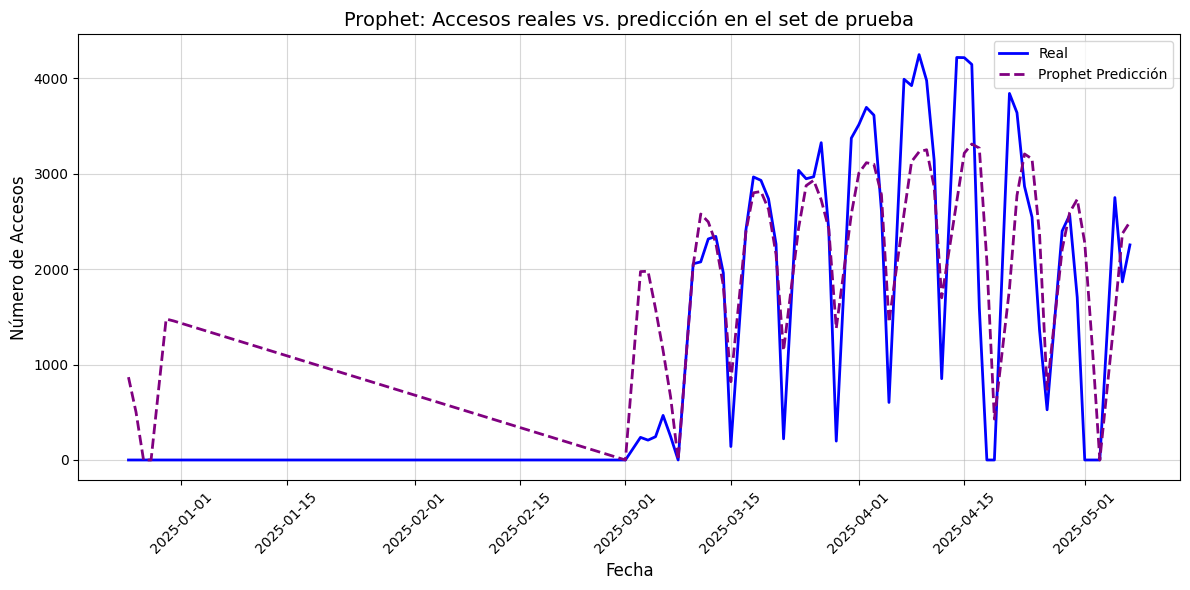


Se ha generado la visualización de la predicción de Prophet.


In [10]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Real', color='blue', linewidth=2)
plt.plot(y_test.index, prophet_predicted, label='Prophet Predicción', color='purple', linestyle='--', linewidth=2)
plt.title('Prophet: Accesos reales vs. predicción en el set de prueba', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de Accesos', fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=10)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

print("\nSe ha generado la visualización de la predicción de Prophet.")